In [228]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Parameter selection, Validation, and Testing

## Hyperparameters, Over-fitting, and Under-fitting

Unfortunately, there is no general rule how to find the sweet spot, and so machine learning practitioners have to find the best trade-off of model-complexity and generalization by trying several hyperparameter settings. Hyperparameters are the internal knobs or tuning parameters of a machine learning algorithm (in contrast to model parameters that the algorithm learns from the training data -- for example, the weight coefficients of a linear regression model); the number of *k* in K-nearest neighbors is such a hyperparameter.

Most commonly this "hyperparameter tuning" is done using a brute force search, for example over multiple values of ``n_neighbors``:


In [229]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
# generate toy dataset:
x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

cv = KFold(shuffle=True)
 
# for each parameter setting do cross-validation:
for n_neighbors in [1, 3, 5, 10, 20]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X, y, cv=cv)
    print("n_neighbors: %d, average score: %f" % (n_neighbors, np.mean(scores)))

n_neighbors: 1, average score: 0.568019
n_neighbors: 3, average score: 0.684980
n_neighbors: 5, average score: 0.755295
n_neighbors: 10, average score: 0.746159
n_neighbors: 20, average score: 0.621792


/home/tigran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


In [230]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(50)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

tr_x, tr_y, te_x, te_y = train_test_split(X, y, test_size=0.2)

knn = KNeighborsRegressor()
knn.fit(tr_x, te_x)
knn.predict(tr_y) == te_y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

There is a function in scikit-learn, called ``validation_plot`` to reproduce the cartoon figure above. It plots one parameter, such as the number of neighbors, against training and validation error (using cross-validation):

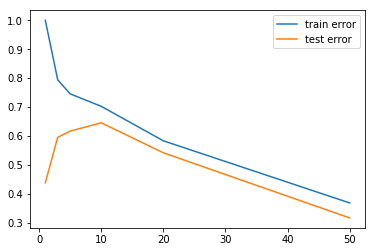

In [231]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 3, 5, 10, 20, 50]
train_errors, test_errors = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)
plt.plot(n_neighbors, train_errors.mean(axis=1), label="train error")
plt.plot(n_neighbors, test_errors.mean(axis=1), label="test error")
plt.legend(loc="best");

Note that many neighbors mean a "smooth" or "simple" model, so the plot is the mirror image of the diagram above.

If multiple parameters are important, like the parameters ``C`` and ``gamma`` in an ``SVM`` (more about that later), all possible combinations are tried:

In [232]:
from sklearn.svm import SVR
SVR()

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [233]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# each parameter setting do cross-validation:
for C in [0.001, 0.01, 0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1, 1]:
        scores = cross_val_score(SVR(C=C, gamma=gamma), X, y, cv=cv)
        print("C: %f, gamma: %f, average score: %f" % (C, gamma, np.mean(scores)))

C: 0.001000, gamma: 0.001000, average score: -0.076590
C: 0.001000, gamma: 0.010000, average score: -0.038207
C: 0.001000, gamma: 0.100000, average score: -0.047551
C: 0.001000, gamma: 1.000000, average score: -0.005575
C: 0.010000, gamma: 0.001000, average score: -0.053052
C: 0.010000, gamma: 0.010000, average score: -0.019979
C: 0.010000, gamma: 0.100000, average score: -0.082264
C: 0.010000, gamma: 1.000000, average score: 0.060893
C: 0.100000, gamma: 0.001000, average score: 0.004787
C: 0.100000, gamma: 0.010000, average score: 0.161750
C: 0.100000, gamma: 0.100000, average score: 0.429838
C: 0.100000, gamma: 1.000000, average score: 0.397513
C: 1.000000, gamma: 0.001000, average score: 0.134488
C: 1.000000, gamma: 0.010000, average score: 0.557693
C: 1.000000, gamma: 0.100000, average score: 0.577646
C: 1.000000, gamma: 1.000000, average score: 0.563442
C: 10.000000, gamma: 0.001000, average score: 0.537522
C: 10.000000, gamma: 0.010000, average score: 0.573970
C: 10.000000, gamma

As this is such a very common pattern, there is a built-in class for this in scikit-learn, ``GridSearchCV``. ``GridSearchCV`` takes a dictionary that describes the parameters that should be tried and a model to train.

The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [234]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=1, )

One of the great things about GridSearchCV is that it is a *meta-estimator*. It takes an estimator like SVR above, and creates a new estimator, that behaves exactly the same - in this case, like a regressor.
So we can call ``fit`` on it, to train it:

In [236]:
grid.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.1s finished
/home/tigran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

What ``fit`` does is a bit more involved then what we did above. First, it runs the same loop with cross-validation, to find the best parameter combination.
Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

Then, as with all models, we can use ``predict`` or ``score``:


In [237]:
grid.predict(X)

array([-2.70831141, -2.62374976, -2.53462546, -2.44653446, -2.36497012,
       -2.29495378, -2.24066414, -2.20509235, -2.18975072, -2.19446204,
       -2.21725283, -2.25436838, -2.30041972, -2.34866308, -2.39140245,
       -2.42049504, -2.42792989, -2.40644155, -2.35011496, -2.25493505,
       -2.11923555, -1.94400577, -1.73302299, -1.49278891, -1.23226293,
       -0.96239998, -0.69551639, -0.44452139, -0.22206434, -0.03965645,
        0.09316967,  0.16959923,  0.18611515,  0.14287008,  0.04381574,
       -0.10342802, -0.28796368, -0.49624586, -0.71291196, -0.92175984,
       -1.1068061 , -1.25335166, -1.34897906, -1.38440943, -1.35415632,
       -1.25692685, -1.09573877, -0.8777417 , -0.61375248, -0.31753503,
       -0.00487398,  0.30749336,  0.60301163,  0.86642842,  1.084822  ,
        1.24846305,  1.35144956,  1.39207066,  1.37287504,  1.30044136,
        1.18486969,  1.03903338,  0.87764782,  0.71622552,  0.56999398,
        0.45285487,  0.37645806,  0.34945459,  0.37697775,  0.46

You can inspect the best parameters found by ``GridSearchCV`` in the ``best_params_`` attribute, and the best score in the ``best_score_`` attribute:

In [238]:
print(grid.best_score_)

0.6611661421585049


In [239]:
print(grid.best_params_)

{'C': 10, 'gamma': 1}


There is a problem with using this score for evaluation, however. You might be making what is called a multiple hypothesis testing error. If you try very many parameter settings, some of them will work better just by chance, and the score that you obtained might not reflect how your model would perform on new unseen data.
Therefore, it is good to split off a separate test-set before performing grid-search. This pattern can be seen as a training-validation-test split, and is common in machine learning:

<img src="grid_search_cross_validation.svg" width="100%">

We can do this very easily by splitting of some test data using ``train_test_split``, training ``GridSearchCV`` on the training set, and applying the ``score`` method to the test set:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

We can also look at the parameters that were selected:

In [ ]:
grid.best_params_

Some practitioners go for an easier scheme, splitting the data simply into three parts, training, validation and testing. This is a possible alternative if your training set is very large, or it is infeasible to train many models using cross-validation because training a model takes very long.
You can do this with scikit-learn for example by splitting of a test-set and then applying GridSearchCV with ShuffleSplit cross-validation with a single iteration:

<img src="train_validation_test2.svg" width="100%">

In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
single_split_cv = ShuffleSplit(n_splits=1)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

This is much faster, but might result in worse hyperparameters and therefore worse results.

In [ ]:
clf = GridSearchCV(SVR(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)